# Uvod u znanost o podacima
## Projekt Faza 2
### Autor: Erik Greblo 0036537734

**Članak:** _Implementation of Machine Learning Model to Predict Heart Failure Disease_

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 1. Učitati podatke

In [2]:
original_data = pd.read_csv("heart_disease_uci.csv")
print(f"{len(original_data)} pacijenta")
original_data[:8]

920 pacijenta


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
5,6,56,Male,Cleveland,atypical angina,120.0,236.0,False,normal,178.0,False,0.8,upsloping,0.0,normal,0
6,7,62,Female,Cleveland,asymptomatic,140.0,268.0,False,lv hypertrophy,160.0,False,3.6,downsloping,2.0,normal,3
7,8,57,Female,Cleveland,asymptomatic,120.0,354.0,False,normal,163.0,True,0.6,upsloping,0.0,normal,0


**OPIS ZNAČAJKI**

**id** - identifikacijski broj

**age** - startost pacijenta [29 - 77]

**sex** - spol [ 0 -> ženski, 1 -> muški]

**dataset** - naziv baze podataka

**cp** - razina boli u prsima [0 - 3]

**trestbps** -krvni tlak pacijenta u bolnici [94 - 200]

**chol** -razina kolesterola pacijenta u bolnici [126 - 564]

**fbs** - razina šećera u krvi natašte [>120mg/dl = 1, inače = 0]

**restecg** - rezultat ECG (electrocardiogram) [0-1-2]

**thalch** - maksimalno očitanje otkucaja srca pacijenta u bolnici [71 - 202]

**exang** - uzrokuje li vježbanje anginu [0,1]

**oldpeek** - pacijentov status depresije [0 - 6.2]

**slope** - stanje pacijenta tijekom vježbanja [_Upsloping_ -> 1, _Flat_ -> 2, _Downsloping_ -> 3]

**ca** - status fluoroskopije [0-1-2-3]

**thal** - rezultat testiranja pacijentove boli prsnog koša / poteškoća disanja [0-1-2-3]

**num** - šansa zatajanja pacijentova srca [_ne postoji šansa_ -> 0, _velika šansa_ -> 1] = **CILJNA VARIJABLA**




** Ciljna varijabla _num_ unutar dataseta sadrži vrijednosti [0-1-2-3], što se može predočiti kao [_ne postoji šansa_ -> 0, _velika šansa_ -> 3] te 1 i 2 su vrijednosti između ekstrema.


## Čišćenje podataka

### 1. Uklanjanje monotonih i konstantnih značajki

Uklanjamo sve značajke čije vrijednosti rastu (ili se smanjuju) bez ograničenja te one koje imaju konstantnu vrijednost.

In [3]:
data = original_data.copy()
monotonous_features = []
constant_features = []
for feature in data[:0]:
    
    if data[feature].nunique() == 1:
        print(f"{feature} je konstantna značajka.")
        constant_features.append(feature)
        
    if data[feature].is_monotonic_increasing:
        print(f"{feature} raste kroz vrijeme (monotono).")
        monotonous_features.append(feature)
    elif data[feature].is_monotonic_decreasing:
        print(f"{feature} opada kroz vrijeme (monotono).")
        monotonous_features.append(feature)
        
    
features_to_remove = monotonous_features + constant_features
data = data.drop(columns=features_to_remove)

id raste kroz vrijeme (monotono).
dataset raste kroz vrijeme (monotono).


### 2. Srediti nedostajuće podatke
Potrebno je odrediti što učiniti sa podacima koji nemaju vrijednost.
Postavljanjem granice (_treshold_) određujemo koliko značajke mogu imati nepostojećih vrijednosti, što utječe na način nošenja s istima.

Ukoliko značajka ima manji postotak nedostajućih vrijednosti od granice, taj podatak možemo obrisati.

Ukoliko je postotak veći od postavljene granice, numeričke značajke postavljamo na medijan iste značajke na cijelom datasetu, a one kategoričke postavimo na najčešću vrijednost unutar dataseta.

In [4]:
null_counts = data.isnull().sum()
null_counts = null_counts[null_counts > 0]
print("Broj Null vrijednosti po značajci:")
print(null_counts)

features_with_null = null_counts.index.tolist()
features_to_fill = []
features_to_delete = []

# Granica postotka nedostajućih vrijednosti
treshold = 10
count = len(data)
print("\nPostotak nedostajućih vrijednosti značajki: ")
for i in range(len(null_counts)):
    feature = features_with_null[i]
    null_values = null_counts[feature]
    percentage = null_values / count * 100
    print(f"Značajki '{feature}' {percentage:0.2f}% od {count} značajki nedostaje.")
    
    if percentage > treshold:
        print("\tPostotak je značajan, zato ćemo zamijeniti nedostajaće vrijednosti medijanom ostalih.")
        features_to_fill.append(feature)
    else:
        print("\tPostotak je dovoljno malen pa možemo zanemariti primjere sa nedostajaćim vrijednostima.")
        features_to_delete.append(feature)
    
# Zanemarivanje primjera sa nedostajućim vrijednostima
data = data.dropna(subset=features_to_delete)

categorical_features = data[features_to_fill].select_dtypes(include=['object', 'category']).columns

features_to_fill_numerical = list(set(features_to_fill) - set(categorical_features))
data.loc[:, features_to_fill_numerical] = data[features_to_fill_numerical].fillna(data[features_to_fill_numerical].median())

print("Kategorijske značkajke: ", categorical_features)   
for feature in categorical_features:
    most_frequent = data[feature].value_counts().index[0]
    data[feature].fillna(most_frequent, inplace=True)

# Provjera
null_counts = data.isnull().sum()
null_counts = null_counts[null_counts > 0]
print("\nBroj Null vrijednosti po značajci:")
print(null_counts)


Broj Null vrijednosti po značajci:
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64

Postotak nedostajućih vrijednosti značajki: 
Značajki 'trestbps' 6.41% od 920 značajki nedostaje.
	Postotak je dovoljno malen pa možemo zanemariti primjere sa nedostajaćim vrijednostima.
Značajki 'chol' 3.26% od 920 značajki nedostaje.
	Postotak je dovoljno malen pa možemo zanemariti primjere sa nedostajaćim vrijednostima.
Značajki 'fbs' 9.78% od 920 značajki nedostaje.
	Postotak je dovoljno malen pa možemo zanemariti primjere sa nedostajaćim vrijednostima.
Značajki 'restecg' 0.22% od 920 značajki nedostaje.
	Postotak je dovoljno malen pa možemo zanemariti primjere sa nedostajaćim vrijednostima.
Značajki 'thalch' 5.98% od 920 značajki nedostaje.
	Postotak je dovoljno malen pa možemo zanemariti primjere sa nedostajaćim vrijednostima.
Značajki 'exang' 5.98% od 920 značajki nedostaje

###  3. Transformacija kategoričkih značajki

Kako bi se uspjelo primijeniti strojno učenje na ovom datasetu, potrebno je kategoričke vrijednosti pretvoriti u numeričke.

Prolaskom kroz sve jedinstvene vrijednosti svake kategoričke značajke, vidljivo je kako svaka nema više od 4 vrijednosti. Iz toga razloga svakoj možemo dodijeliti indeks za pojedinu vrijednost.


In [5]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns

# Ispis kategoričkih značajki i njihovih kategorija
for feature in categorical_features:
    unique_values = data[feature].unique()
    print(f"Značajka '{feature}' ima sljedećih {len(unique_values)} kategorija: {unique_values}")
    
mappings = {}
for feature in categorical_features:
    unique_categories = data[feature].unique()
    mappings[feature] = {category: idx for idx, category in enumerate(unique_categories)}
    data[feature] = data[feature].map(mappings[feature])

print()
for feature in categorical_features:
    unique_values = data[feature].unique()
    print(f"Značajka '{feature}' ima sljedećih {len(unique_values)} numeričkih kategorija: {unique_values}")


Značajka 'sex' ima sljedećih 2 kategorija: ['Male' 'Female']
Značajka 'cp' ima sljedećih 4 kategorija: ['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
Značajka 'fbs' ima sljedećih 2 kategorija: [True False]
Značajka 'restecg' ima sljedećih 3 kategorija: ['lv hypertrophy' 'normal' 'st-t abnormality']
Značajka 'exang' ima sljedećih 2 kategorija: [False True]
Značajka 'slope' ima sljedećih 3 kategorija: ['downsloping' 'flat' 'upsloping']
Značajka 'thal' ima sljedećih 3 kategorija: ['fixed defect' 'normal' 'reversable defect']

Značajka 'sex' ima sljedećih 2 numeričkih kategorija: [0 1]
Značajka 'cp' ima sljedećih 4 numeričkih kategorija: [0 1 2 3]
Značajka 'fbs' ima sljedećih 2 numeričkih kategorija: [0 1]
Značajka 'restecg' ima sljedećih 3 numeričkih kategorija: [0 1 2]
Značajka 'exang' ima sljedećih 2 numeričkih kategorija: [0 1]
Značajka 'slope' ima sljedećih 3 numeričkih kategorija: [0 1 2]
Značajka 'thal' ima sljedećih 3 numeričkih kategorija: [0 1 2]


**Prikaz korisnih vrijednosti numeričkih značajki:**

In [6]:
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_features:
    mean = data[feature].mean()
    median = data[feature].median()
    max_val = data[feature].max()
    min_val = data[feature].min()
    print(f"Značajka {feature} :")
    print(f"\tsrednja vrijednost: {mean}")
    print(f"\tcentralna vrijednost: {median}")    
    print(f"\tmin. vrijednost: {min_val}")    
    print(f"\tmax vrijednost: {max_val}") 
    
for feature in categorical_features:
    unique_values = data[feature].unique()
    print(f"Značajka '{feature}' ima sljedeću učestalost pojedinih  kategorija:")
    print(data[feature].value_counts())
    print("-----")

Značajka age :
	srednja vrijednost: 53.097297297297295
	centralna vrijednost: 54.0
	min. vrijednost: 28
	max vrijednost: 77
Značajka sex :
	srednja vrijednost: 0.23513513513513515
	centralna vrijednost: 0.0
	min. vrijednost: 0
	max vrijednost: 1
Značajka cp :
	srednja vrijednost: 1.572972972972973
	centralna vrijednost: 1.0
	min. vrijednost: 0
	max vrijednost: 3
Značajka trestbps :
	srednja vrijednost: 132.75405405405405
	centralna vrijednost: 130.0
	min. vrijednost: 0.0
	max vrijednost: 200.0
Značajka chol :
	srednja vrijednost: 220.1364864864865
	centralna vrijednost: 231.0
	min. vrijednost: 0.0
	max vrijednost: 603.0
Značajka fbs :
	srednja vrijednost: 0.85
	centralna vrijednost: 1.0
	min. vrijednost: 0
	max vrijednost: 1
Značajka restecg :
	srednja vrijednost: 0.9256756756756757
	centralna vrijednost: 1.0
	min. vrijednost: 0
	max vrijednost: 2
Značajka thalch :
	srednja vrijednost: 138.7445945945946
	centralna vrijednost: 140.0
	min. vrijednost: 60.0
	max vrijednost: 202.0
Značajka

### 4. Normalizacija numeričkih značajki

Zbog različitih skala mjerenja značajki dataseta, potrebno je odraditi normalizaciju numeričkih značaki kako bi sve značajke bile jednako relevantne pri izračunu.

U sljedećem kodu koristi se normalizacija **Min-Max**.

In [7]:
for feature in numerical_features:
    max_val = data[feature].max()
    min_val = data[feature].min()
    data[feature] = (data[feature] - min_val) / (max_val - min_val)

print("Prikaz prvih 8 redova normaliziranih podataka: \n")
data[:8]

Prikaz prvih 8 redova normaliziranih podataka: 



,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,0.714286,0.0,0.000000,0.725,0.386401,0.0,0.0,0.633803,0.0,0.458333,0.0,0.000000,0.0,0.00
1,0.795918,0.0,0.333333,0.800,0.474295,1.0,0.0,0.338028,1.0,0.347222,0.5,1.000000,0.5,0.50
2,0.795918,0.0,0.333333,0.600,0.379768,1.0,0.0,0.485915,1.0,0.500000,0.5,0.666667,1.0,0.25
3,0.183673,0.0,0.666667,0.650,0.414594,1.0,0.5,0.894366,0.0,0.625000,0.0,0.000000,0.5,0.00
4,0.265306,1.0,1.000000,0.650,0.338308,1.0,0.0,0.788732,0.0,0.333333,1.0,0.000000,0.5,0.00
5,0.571429,0.0,1.000000,0.600,0.391376,1.0,0.5,0.830986,0.0,0.250000,1.0,0.000000,0.5,0.00
6,0.693878,1.0,0.333333,0.700,0.444444,1.0,0.0,0.704225,0.0,0.638889,0.0,0.666667,0.5,0.75
7,0.591837,1.0,0.333333,0.600,0.587065,1.0,0.5,0.725352,1.0,0.222222,1.0,0.000000,0.5,0.00


### Vizualizacija podataka

Kako bi omogućili jednostavno očitavanje korisnosti podataka dataseta, moguće je kreirati grafove iz kojih je moguće doći do korisnih zaključka.

**Histogrami:**
- Uz pomoć stupičastih grafova (histograma), možemo predočiti sa kakvim podacima baratamo. 
- Korisno je vidjeti raspodjelu godina pacijenata u datasetu, kao i količina pacijenta sa niskom/visokom šansom zatajanja srca

Text(0.5, 0, 'num')

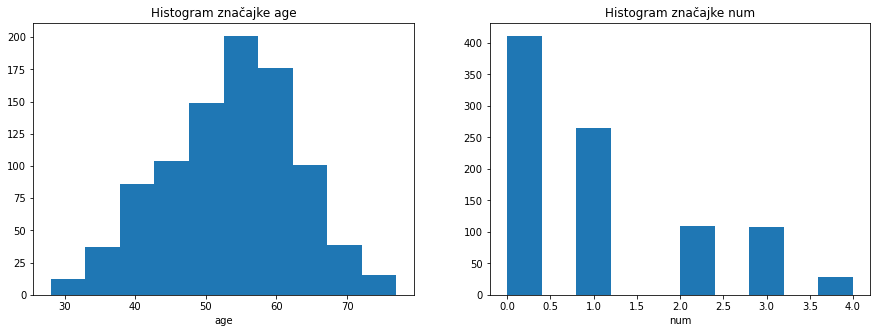

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(original_data['age'])
axs[0].set_title("Histogram značajke age")
axs[0].set_xlabel("age")

axs[1].hist(original_data['num'])
axs[1].set_title("Histogram značajke num")
axs[1].set_xlabel("num")

**Pitni grafovi:**
- Uz pomoć pitnih grafova, jednostavno možemo predočiti omjer jedinstvenih vrijednosti određenih kategoričkih značajki.
- U sljedećem kodu prikazuje se pitni graf varijeble cp (bol u prsima) te slope (stanje pacijenta tijekom vježbanja), čime možemo vidjeti raspodijelu različih vrijednosti kroz cijeli dataset.

Text(0.5, 1.0, 'Pitni graf varijable slope')

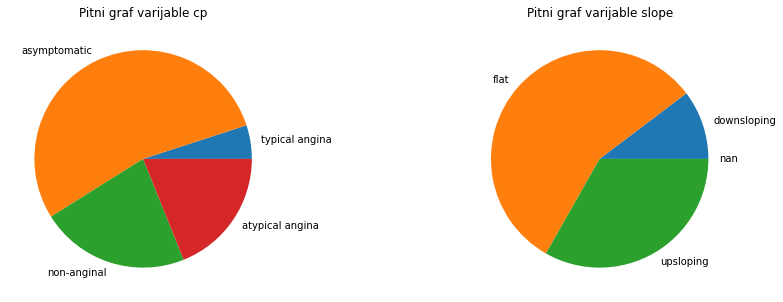

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

labels = original_data['cp'].unique()
counts = original_data['cp'].value_counts().reindex(labels, fill_value=0).tolist()
axs[0].pie(counts, labels=labels)
axs[0].set_title("Pitni graf varijable cp")


labels = original_data['slope'].unique()
counts = original_data['slope'].value_counts().reindex(labels, fill_value=0).tolist()
axs[1].pie(counts, labels=labels)
axs[1].set_title("Pitni graf varijable slope")

**Kutijasti grafovi:**
- Za prikazivanje distribucije podataka, uočavanje odstupanja te indikaciju asimetrije, koristimo kutijaste grafove (_box plots_)
- Prvi kutijasti graf prikazuje značajku _num_ ovisno o _slope_. Možemo očitati kako je opasnost otkazivanja srca pacijenta koji ima _downsloping_ slope u prosjeku veća nego onih sa _flat_ ili _upsloping_ vrijednostima.
- Drugi kutijasti graf prikazuje značajku _age_ (starost pacijenta) ovisno o značajki _restecg_ (rezultat ECG). Vidljivo je kako u prosjeku mlađi ljudi imaju _normalni_ rezultat ECG testa, zato što je medijan godina pacijenta u središnjem stupcu niži od ostalih.


Text(0, 0.5, 'age')

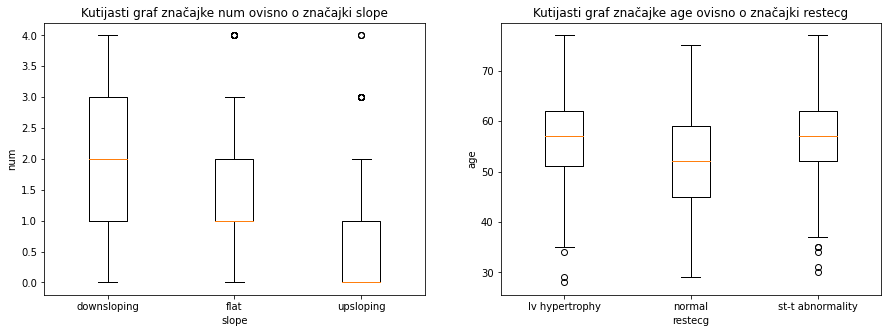

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

label_name = 'num'
feature_name = 'slope'

downsloping = original_data[original_data[feature_name] == 'downsloping'][label_name]
flat = original_data[original_data[feature_name] == 'flat'][label_name]
upsloping = original_data[original_data[feature_name] == 'upsloping'][label_name]

boxdata = [downsloping, flat, upsloping]
axs[0].boxplot(boxdata, labels=['downsloping', 'flat', 'upsloping'])
axs[0].set_title(f"Kutijasti graf značajke {label_name} ovisno o značajki {feature_name}")
axs[0].set_xlabel(feature_name)
axs[0].set_ylabel(label_name)

label_name = 'age'
feature_name = 'restecg'

lv = original_data[original_data[feature_name] == 'lv hypertrophy'][label_name]
normal = original_data[original_data[feature_name] == 'normal'][label_name]
stt = original_data[original_data[feature_name] == 'st-t abnormality'][label_name]

boxdata = [lv, normal, stt]
axs[1].boxplot(boxdata, labels=['lv hypertrophy', 'normal', 'st-t abnormality'])
axs[1].set_title(f"Kutijasti graf značajke {label_name} ovisno o značajki {feature_name}")
axs[1].set_xlabel(feature_name)
axs[1].set_ylabel(label_name)

**Grafovi raspršenja:**
- Savršen graf za otkrivanje korelacije značajki, pregled raznovrsnosti podataka te višedimenzionalnu analizu jest graf raspršenja (_scatter plot_)
- U prvome grafu prikazujemo značajke _trestbps_ (krvni tlak pacijenta u bolnici) i _thalch_ (maksimalno očitanje otkucaja srca pacijenta u bolnici). Promatranjem boje točaka podataka, može se zaključiti kako _trestbps_ nema značajan utjecaj na _num_ (šansa zatajanja pacijentova srca), zato što boja točaka ne ovisi pretjerano o položaju na x osi. S druge strane, vidljiv je gradijent boje uz y os, _thalch_. Pacijenti sa nižom vrijednosti imaju veću šansu zatajanja srca, zato što su točke pri vrhu obojane ljubičastom bojom (_num_ = 0), a pri dnu zelenom/žutom.
- Slijedeći graf prikazuje odnos značajki _age_ (starost pacijenta) i _chol_ (razina kolesterola pacijenta u bolnici) s  šansom zatajanja srca. Ponovo, vidljivo je kako _chol_ nema pretjerani utjecaj, no veće godine ukazuju na veće šanse zatajanja pacijentova srca.

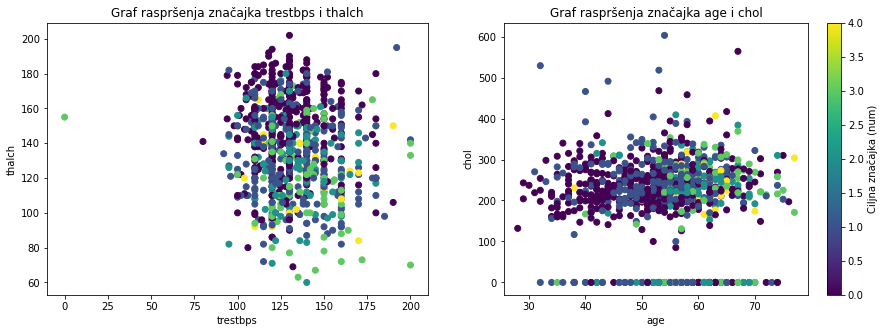

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

label1 = 'trestbps'
label2 = 'thalch'
scatter = axs[0].scatter(original_data[label1], original_data[label2],  c=original_data['num'], cmap='viridis')
axs[0].set_xlabel(label1)
axs[0].set_ylabel(label2)
axs[0].set_title(f"Graf raspršenja značajka {label1} i {label2}")

label1 = 'age'
label2 = 'chol'
axs[1].scatter(original_data[label1], original_data[label2],  c=original_data['num'], cmap='viridis')
axs[1].set_xlabel(label1)
axs[1].set_ylabel(label2)
axs[1].set_title(f"Graf raspršenja značajka {label1} i {label2}")

cbar = plt.colorbar(scatter, ax=axs[1])
cbar.set_label('Ciljna značajka (num)')